In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt
import scipy.stats as st

Implement the model of section 9.5 in PyMC3 (the baseball players), probably the most interesting model in the chapter, but technically not much new is happening.
I find this model in week080 jupyter notebook. For more details refer to that notebook.

In [2]:
data = pd.read_csv('BattingAverage.csv')
n_categories = len(data.PriPosNumber.unique())
n_players = len(data)
positions = data.PriPosNumber.to_numpy() -1 

def pos_name(i):
    pos_names = data[ (data.PriPosNumber -1 == i) ].PriPos
    return pos_names.head(1).item()

def name_pos(name):
    pos_numbers = data[ (data.PriPos == name) ].PriPosNumber - 1
    return pos_numbers.head(1).item()

    
with pm.Model() as model:
    # the top-level prior (Hyper-parameters)
    omega = pm.Beta ("omega", 1,1)
    kappa = pm.Deterministic(
        "kappa", 
        pm.Gamma ("kappa_minus_2", 0.01, 0.01) + 2
    )
    
    # paramaters for primary field positions
    omega_c = pm.Beta (
        "omega_c",      
        omega * (kappa-2) +1, 
        (1-omega)*(kappa-2) +1, 
        shape=n_categories
    )
    
    kappa_c = pm.Deterministic (
        "kappa_c",
        pm.Gamma ("kappa_c_minus_2", 0.01, 0.01, shape=n_categories) + 2
    )
    
    # parameters for individual player 
    theta = pm.Beta('theta',
                     omega_c[positions]*(kappa_c[positions]-2)+1,
                    (1-omega_c[positions])*(kappa_c[positions]-2)+1,
                     shape = n_players)
    
    # We are using the same "speed-up" trick as Kruschke is doing, 
    # modeling experiences of each player as a Binomial distribution.
    # Note that above we have produced the theta vector in the same 
    # order as the players in the file, so the observed data in the 
    # binomial distribution will be applied correctly, per each of the 
    # variables in the vector.  It seems that because theta is a vector, 
    # the entire y variable is automatically vectorized.
    
    y = pm.Binomial (
        'y', 
        n = data.AtBats.values, 
        p=theta, 
        observed=data.Hits,
        shape=n_players)
    
    # We add two derived variables in order to make plotting easier:
    omega_pc = pm.Deterministic (
        "omega_pc", 
        omega_c[name_pos("Pitcher")] - omega_c[name_pos("Catcher")]
    )
    omega_c1 = pm.Deterministic (
        "omega_c1", 
        omega_c[name_pos("Catcher")] - omega_c[name_pos("1st Base")]
    )


In [3]:
with model:
    trace = pm.sample (5000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_c_minus_2, omega_c, kappa_minus_2, omega]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [04:14<00:00, 86.37draws/s] 
The number of effective samples is smaller than 10% for some parameters.


In [4]:
az.summary (trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
omega,0.227,0.023,0.184,0.269,0.000,0.000,9794.0,9794.0,13010.0,8025.0,1.0
kappa_minus_2,59.522,32.246,7.525,118.262,0.278,0.197,13439.0,13439.0,10825.0,8839.0,1.0
kappa,61.522,32.246,9.525,120.262,0.278,0.197,13439.0,13439.0,10825.0,8839.0,1.0
omega_c[0],0.122,0.007,0.110,0.134,0.000,0.000,1248.0,1248.0,1255.0,3030.0,1.0
omega_c[1],0.237,0.005,0.227,0.247,0.000,0.000,8230.0,8230.0,8239.0,11123.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
theta[945],0.154,0.030,0.100,0.211,0.000,0.000,12963.0,11928.0,13951.0,12575.0,1.0
theta[946],0.111,0.026,0.060,0.159,0.000,0.000,10872.0,10872.0,9821.0,8650.0,1.0
theta[947],0.266,0.015,0.239,0.294,0.000,0.000,22144.0,22144.0,22073.0,13435.0,1.0
omega_pc,-0.115,0.009,-0.132,-0.100,0.000,0.000,1853.0,1853.0,1852.0,4915.0,1.0


The above should be enough for the week, but Exercises 9.1 and 9.2 are also interesting, if you still have time (or you can look at them in the catch up week)

Exercise 9.1. [Purpose: Try different priors on κ to explore the role of κ
in shrinkage.] Consider the analysis of the therapeutic touch data in Figure 9.10,
p. 243. The analysis used a generic gamma distributed prior on κ that had a mean of 1.0
and a standard deviation of 10.0. We assumed that the prior had minimal influence
on the results; here, we examine the robustness of the posterior when we change
the prior to other reasonably vague and noncommittal distributions. In particular, we
will examine a gamma distributed prior on κ that had a mode of 1.0 and a standard
deviation of 10.0.

(A) What are the shape and rate parameters for a gamma distribution that has mean
of 1.0 and standard deviation of 10.0? What are the shape and rate parameters for a
gamma distribution that has mode of 1.0 and standard deviation of 10.0? Hint: use the
utility functions gammaShRaFromMeanSD and gammaShRaFrom ModeSD .
<font color='blue'> 
mean=1.0 and standard deviation=10.0 give (shape=0.01, rate=0.01)
mode=1.0 and standard deviation=10.0 give (shape=1.105124921972504, rate=0.10512492197250393)
<font/>
    
(B) Plot the two gamma distributions, superimposed, to see which values of κ they
emphasize.
The result is shown in Figure 9.18. Relative to each other, which gamma distribution
favors values of κ between about 0.1 and 75? Which gamma distribution favors values
of κ that are tiny or greater than 75?
<font color='blue'> 
When Mode=1, gamma has higher density for (k form 0.1 to 75). But whe Mean=1 gamma has higher density for (k > 75).
<font/>

(C) In the program Jags-Ydich-XnomSsubj-MbinomBetaOmegaKappa.R, find the
line in the model specification for the prior on kappaMinusTwo . Run the pro-
gram once using a gamma with mean of 1.0, and run the program a second time
using a gamma with a mode of 1.0. Show the graphs of the posterior distribu-
tion. Hints: in the model specification, just comment out one or the other of the
lines:
#kappaMinusTwo  ̃ dgamma( 0.01 , 0.01 ) # mean=1 , sd=10 (generic vague)
kappaMinusTwo  ̃ dgamma( 1.105125 , 0.1051249 ) # mode=1 , sd=10
Be sure to save the program before calling it from the script! In the script, you might
want to change the file name root that is used for saved graph files.

(D) Does the posterior distribution change much when the prior is changed? In
particular, for which prior does the marginal posterior distribution on κ have a bigger
large-value tail? When κ is larger, what effect does that have on shrinkage of the θ s values?
<font color='blue'>     
Using mean=1 for kappa, the posterior on kappa has a larger tail than
using the mode=1. When kappa is larger, the individual theta values
shrunk more. Look at theta[1] and theta[28]. More shrinkage when mean=1 than mode=1 prior.
<font/>

(E) Which prior do you think is more appropriate? To properly answer this question,
you should do the next exercise!
<font color='blue'> 
mean=1
    <font/>

In [5]:
# A) P. 235

def gammaShRaFromMeanSD(Mean, SD):
    if Mean > 0:
        s = Mean**2 / SD**2
        r = Mean / SD**2
    else:
        raise Exception("Mean must be greater than 0")
    return s, r
    

def gammaShRaFromModeSD(Mode, SD):
    if Mode > 0:
            r = (Mode + np.sqrt(Mode**2 + 4 * SD**2)) / (2 * SD**2)
            s = 1 + Mode * r
    else:
        raise Exception("Mode must be greater than 0")
    return s, r

print(gammaShRaFromMeanSD(1.0, 10.0), gammaShRaFromModeSD(1.0, 10.0), sep='\n')

(0.01, 0.01)
(1.105124921972504, 0.10512492197250393)


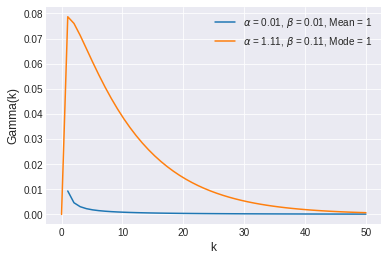

In [6]:
# B)
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 50)
alphas = [0.01, 1.105124921972504]
betas = [0.01, 0.10512492197250393]

for a, b in zip(alphas, betas):
    pdf = st.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=
             r'$\alpha$ = {:0.2f}, $\beta$ = {:0.2f}, {m} = 1'.format(
                 a, b, m="Mode" if a != 0.01 else "Mean"))
plt.xlabel('k', fontsize=12)
plt.ylabel('Gamma(k)', fontsize=12)
plt.legend(loc='best');

In [7]:
# C)
myData = pd.read_csv('TherapeuticTouchData.csv') # the dataset from the book's bundle
IDs = myData['s'].unique()  # List of subjects                                                                                                                                                                                              
S = len(IDs)

def f (cid):
    return myData.loc[ myData['s'] == cid ]['y'].to_numpy()     

trials = np.transpose(np.asarray([f(s) for s in IDs], dtype=np.float32))

In [8]:
with pm.Model() as model_therapeutic_Mean1:
    omega = pm.Beta ("omega", 1, 1)    
    kappa = pm.Deterministic ("kappa", 2+pm.Gamma ("kappaMinusTwo", alpha=0.01, beta=0.01)) # Mean 1
    theta = pm.Beta ("theta", alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=S) 
    y = pm.Bernoulli ("y", p=theta, observed=trials, shape=S)
    
    trace_Mean1 = pm.sample(20000, tune=3000, target_accept=0.95)    
    
with pm.Model() as model_therapeutic_Mode1:
    omega = pm.Beta ("omega", 1, 1)    
    kappa = pm.Deterministic (
        "kappa", 2+pm.Gamma ("kappaMinusTwo", alpha=1.105124921972504, beta=0.10512492197250393)) # Mode 1
    theta = pm.Beta ("theta", alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=S) 
    y = pm.Bernoulli ("y", p=theta, observed=trials, shape=S)
    
    trace_Mode1= pm.sample(20000, tune=3000, target_accept=0.95)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, kappaMinusTwo, omega]
Sampling 2 chains, 0 divergences: 100%|██████████| 46000/46000 [02:22<00:00, 323.88draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, kappaMinusTwo, omega]
Sampling 2 chains, 0 divergences: 100%|██████████| 46000/46000 [01:40<00:00, 456.42draws/s]


In [9]:
az.summary (trace_Mean1, var_names=['omega', 'kappa', 'theta']).head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
omega,0.435,0.038,0.365,0.506,0.000,0.000,11911.0,11911.0,11800.0,20140.0,1.0
kappa,57.516,59.666,3.781,161.987,1.070,0.757,3109.0,3109.0,2973.0,5720.0,1.0
theta[0],0.361,0.088,0.186,0.519,0.001,0.001,9149.0,9149.0,9677.0,16367.0,1.0
theta[1],0.384,0.083,0.225,0.540,0.001,0.001,13713.0,13713.0,14379.0,18230.0,1.0
theta[2],0.407,0.080,0.251,0.556,0.001,0.000,23632.0,23632.0,24038.0,21139.0,1.0


In [10]:
az.summary (trace_Mode1, var_names=['omega', 'kappa', 'theta']).head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
omega,0.433,0.041,0.354,0.509,0.000,0.000,20957.0,20957.0,21001.0,25853.0,1.0
kappa,22.332,11.429,5.634,43.186,0.111,0.079,10555.0,10555.0,10202.0,19305.0,1.0
theta[0],0.324,0.094,0.148,0.500,0.001,0.000,31941.0,31941.0,31764.0,24001.0,1.0
theta[1],0.358,0.094,0.182,0.535,0.000,0.000,43208.0,43208.0,42752.0,24556.0,1.0
theta[2],0.392,0.093,0.216,0.565,0.000,0.000,55579.0,55030.0,55236.0,26462.0,1.0


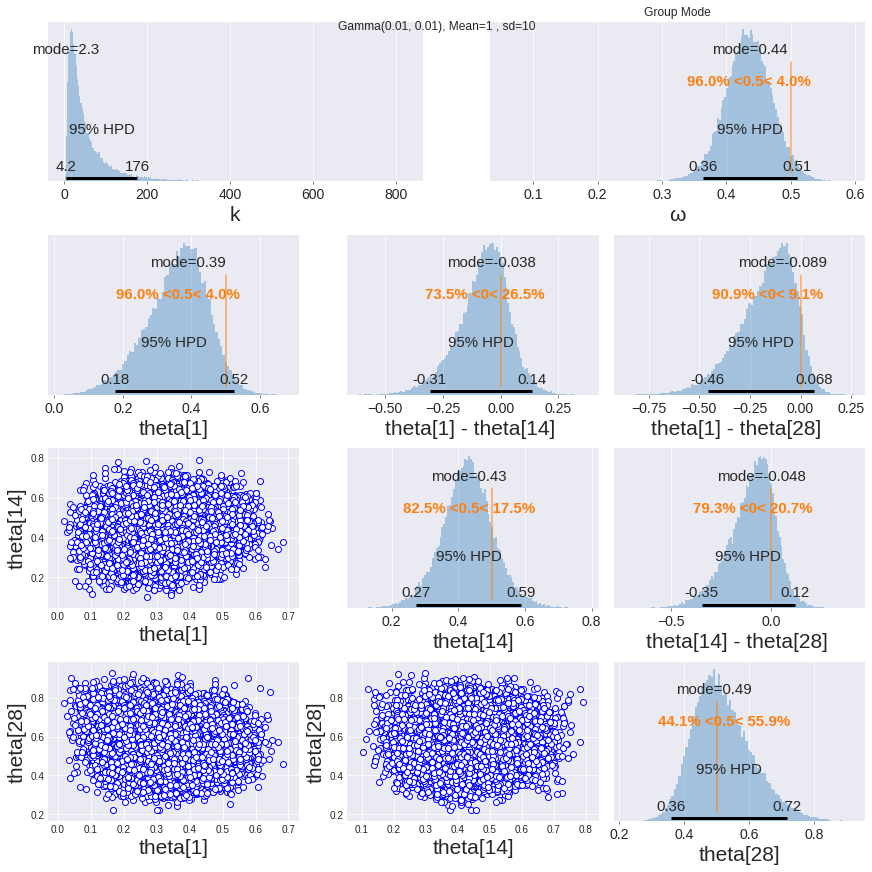

In [11]:
from matplotlib import gridspec
fig_Mean1 = plt.figure(constrained_layout=True, figsize=(12,12))
fig_Mean1.suptitle('Gamma(0.01, 0.01), Mean=1 , sd=10', fontsize=12)
gs = fig_Mean1.add_gridspec(4, 9)
f3_ax1 = fig_Mean1.add_subplot(gs[0, :4])
f3_ax2 = fig_Mean1.add_subplot(gs[0, 5:])
f3_ax3 = fig_Mean1.add_subplot(gs[1, :3])
f3_ax4 = fig_Mean1.add_subplot(gs[1, 3:6])
f3_ax5 = fig_Mean1.add_subplot(gs[1, 6:])
f3_ax6 = fig_Mean1.add_subplot(gs[2, :3])
f3_ax7 = fig_Mean1.add_subplot(gs[2, 3:6])
f3_ax8 = fig_Mean1.add_subplot(gs[2, 6:])
f3_ax9 = fig_Mean1.add_subplot(gs[3, :3])
f3_ax10 = fig_Mean1.add_subplot(gs[3, 3:6])
f3_ax11 = fig_Mean1.add_subplot(gs[3, 6:])


pm.plot_posterior(
    trace_Mean1['kappa'], ax=f3_ax1, point_estimate='mode', 
    credible_interval=0.95, kind='hist'
)
f3_ax1.set_title("")
f3_ax1.set_xlabel("k", fontsize='21')

pm.plot_posterior(
    trace_Mean1['omega'], ax=f3_ax2, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0.5
)
f3_ax2.set_title("Group Mode")
f3_ax2.set_xlabel("ω", fontsize='21')

pm.plot_posterior(
    trace_Mean1['theta'][:, 0], ax=f3_ax3, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0.5
)
f3_ax3.set_title("")
f3_ax3.set_xlabel("theta[1]", fontsize='21')

pm.plot_posterior(
    trace_Mean1['theta'][:, 0] - trace_Mean1['theta'][:, 13], ax=f3_ax4, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0
)
f3_ax4.set_title("")
f3_ax4.set_xlabel("theta[1] - theta[14] ", fontsize='21')

pm.plot_posterior(
    trace_Mean1['theta'][:, 0] - trace_Mean1['theta'][:, 27], ax=f3_ax5, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0
)
f3_ax5.set_title("")
f3_ax5.set_xlabel("theta[1] - theta[28] ", fontsize='21')


f3_ax6.scatter(trace_Mean1['theta'][:, 0], trace_Mean1['theta'][:, 13],
               color='blue', facecolor='white')
f3_ax6.set_xlabel("theta[1]", fontsize='21')
f3_ax6.set_ylabel("theta[14]", fontsize='21')


pm.plot_posterior(
    trace_Mean1['theta'][:, 13], ax=f3_ax7, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0.5
)
f3_ax7.set_title("")
f3_ax7.set_xlabel("theta[14]", fontsize='21')


pm.plot_posterior(
    trace_Mean1['theta'][:, 13] - trace_Mean1['theta'][:, 27], ax=f3_ax8, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0
)
f3_ax8.set_title("")
f3_ax8.set_xlabel("theta[14] - theta[28] ", fontsize='21')


f3_ax9.scatter(trace_Mean1['theta'][:, 0], trace_Mean1['theta'][:, 27],
               color='blue', facecolor='white')
f3_ax9.set_xlabel("theta[1]", fontsize='21')
f3_ax9.set_ylabel("theta[28]", fontsize='21')


f3_ax10.scatter(trace_Mean1['theta'][:, 13], trace_Mean1['theta'][:, 27],
                color='blue', facecolor='white')
f3_ax10.set_xlabel("theta[14]", fontsize='21')
f3_ax10.set_ylabel("theta[28]", fontsize='21')


pm.plot_posterior(
    trace_Mean1['theta'][:, 27], ax=f3_ax11, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0.5
)
f3_ax11.set_title("")
f3_ax11.set_xlabel("theta[28]", fontsize='21');


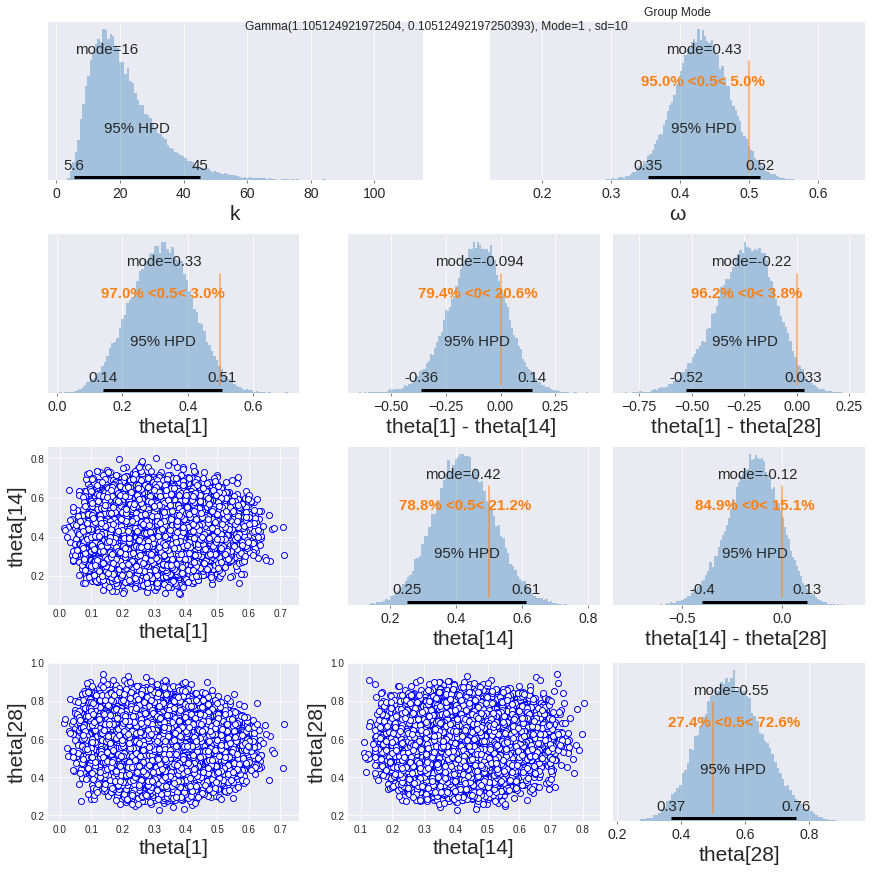

In [12]:
from matplotlib import gridspec
fig_Mode1 = plt.figure(constrained_layout=True, figsize=(12,12))
fig_Mode1.suptitle('Gamma(1.105124921972504, 0.10512492197250393), Mode=1 , sd=10', fontsize=12)

gs = fig_Mode1.add_gridspec(4, 9)
f3_ax1 = fig_Mode1.add_subplot(gs[0, :4])
f3_ax2 = fig_Mode1.add_subplot(gs[0, 5:])
f3_ax3 = fig_Mode1.add_subplot(gs[1, :3])
f3_ax4 = fig_Mode1.add_subplot(gs[1, 3:6])
f3_ax5 = fig_Mode1.add_subplot(gs[1, 6:])
f3_ax6 = fig_Mode1.add_subplot(gs[2, :3])
f3_ax7 = fig_Mode1.add_subplot(gs[2, 3:6])
f3_ax8 = fig_Mode1.add_subplot(gs[2, 6:])
f3_ax9 = fig_Mode1.add_subplot(gs[3, :3])
f3_ax10 = fig_Mode1.add_subplot(gs[3, 3:6])
f3_ax11 = fig_Mode1.add_subplot(gs[3, 6:])


pm.plot_posterior(
    trace_Mode1['kappa'], ax=f3_ax1, point_estimate='mode', 
    credible_interval=0.95, kind='hist'
)
f3_ax1.set_title("")
f3_ax1.set_xlabel("k", fontsize='21')

pm.plot_posterior(
    trace_Mode1['omega'], ax=f3_ax2, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0.5
)
f3_ax2.set_title("Group Mode")
f3_ax2.set_xlabel("ω", fontsize='21')

pm.plot_posterior(
    trace_Mode1['theta'][:, 0], ax=f3_ax3, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0.5
)
f3_ax3.set_title("")
f3_ax3.set_xlabel("theta[1]", fontsize='21')

pm.plot_posterior(
    trace_Mode1['theta'][:, 0] - trace_Mode1['theta'][:, 13], ax=f3_ax4, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0
)
f3_ax4.set_title("")
f3_ax4.set_xlabel("theta[1] - theta[14] ", fontsize='21')

pm.plot_posterior(
    trace_Mode1['theta'][:, 0] - trace_Mode1['theta'][:, 27], ax=f3_ax5, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0
)
f3_ax5.set_title("")
f3_ax5.set_xlabel("theta[1] - theta[28] ", fontsize='21')


f3_ax6.scatter(trace_Mode1['theta'][:, 0], trace_Mode1['theta'][:, 13],
              color='blue', facecolor='white')
f3_ax6.set_xlabel("theta[1]", fontsize='21')
f3_ax6.set_ylabel("theta[14]", fontsize='21')


pm.plot_posterior(
    trace_Mode1['theta'][:, 13], ax=f3_ax7, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0.5
)
f3_ax7.set_title("")
f3_ax7.set_xlabel("theta[14]", fontsize='21')


pm.plot_posterior(
    trace_Mode1['theta'][:, 13] - trace_Mode1['theta'][:, 27], ax=f3_ax8, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0
)
f3_ax8.set_title("")
f3_ax8.set_xlabel("theta[14] - theta[28] ", fontsize='21')


f3_ax9.scatter(trace_Mode1['theta'][:, 0], trace_Mode1['theta'][:, 27],
              color='blue', facecolor='white')
f3_ax9.set_xlabel("theta[1]", fontsize='21')
f3_ax9.set_ylabel("theta[28]", fontsize='21')


f3_ax10.scatter(trace_Mode1['theta'][:, 13], trace_Mode1['theta'][:, 27],
               color='blue', facecolor='white')
f3_ax10.set_xlabel("theta[14]", fontsize='21')
f3_ax10.set_ylabel("theta[28]", fontsize='21')


pm.plot_posterior(
    trace_Mode1['theta'][:, 27], ax=f3_ax11, point_estimate='mode', 
    credible_interval=0.95, kind='hist', ref_val=0.5
)
f3_ax11.set_title("")
f3_ax11.set_xlabel("theta[28]", fontsize='21');


Exercise 9.2. [Purpose: Examine the prior on θ s implied by the prior
constants at higher levels.] To sample from the prior in JAGS, we just comment
out the data, as was explained in Section 8.5. In the program Jags-Ydich-XnomSsubj-
MbinomBetaOmegaKappa.R, just comment out the line that specifies z , like this:

dataList = list(

/# z = z ,

N = N ,

Nsubj = Nsubj

)


Save the program, and run it with the two priors on κ discussed in the previous exercise.
You may want to change the file name root for the saved graphics files. For both priors,
include the graphs of the prior distributions on θ s and the differences of θ s ’s such as
theta[1]-theta[28] . See Figure 9.19.

(A) Explain why the implied prior distribution on individual θ s has rounded
shoulders (instead of being essentially uniform) when using a prior on κ that has a mode
of 1 (instead of a mean of 1).
<font color='blue'>
When using kappa with mean=1, kappa can be a number approximately between 2 and 3 but setting it to mode=1, it will produce any number from 2 to 33. In the case of kappa with mean=1, the individual theta prior distributions are uniformly distributed as you can see in figure 9.19. It will make it more likely to get two extremely different values of theta prior. On the other hand, using kappa with mode=1 cause to the individual theta prior distribute kind of bell-shaped distribution with large sd. Therefore it will often produce values around the center. <font/>
    

(B) Which prior do you think is more appropriate?
<font color='blue'>
I believe mean=1 prior to kappa. Since we want a uniform prior for individual theta.
<font/>

![title](Figure9.19.png)

In [13]:
with model_therapeutic_Mean1:
    prior_Mean1 = pm.sample_prior_predictive(20000) 
    
with model_therapeutic_Mode1:
    prior_Mode1 = pm.sample_prior_predictive(20000) 

95% HPD of kappa prior with mean1 is from  2.00 to  2.34
95% HPD of kappa prior with mode1 is from  2.00 to  32.34


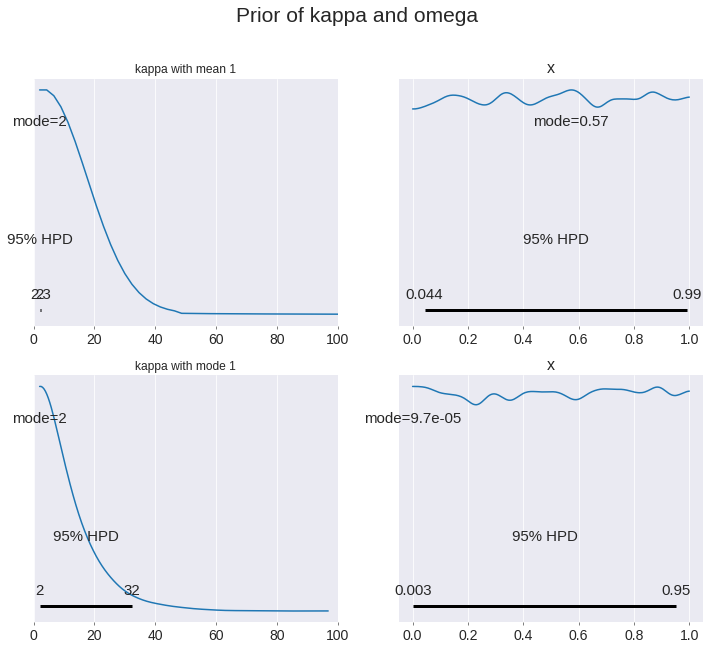

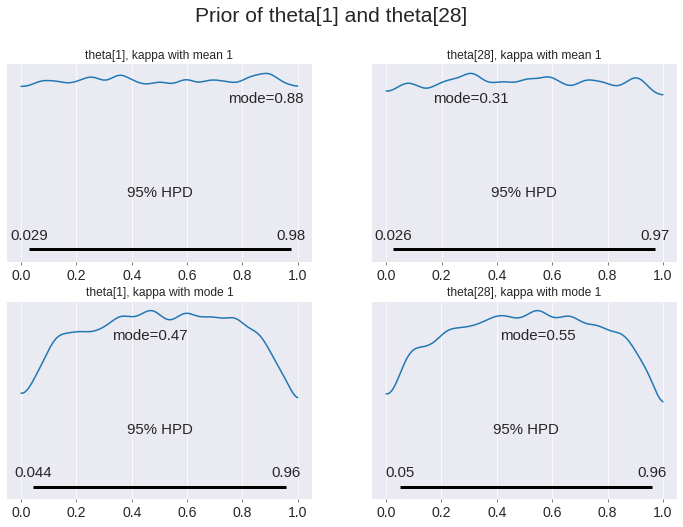

In [14]:
fig_prior, prior_ax = plt.subplots(2,2,figsize=(12,10))
fig_prior.suptitle('Prior of kappa and omega', fontsize=21)

hpd_Mean1 = az.hpd(prior_Mean1['kappa'], credible_interval=.95)
hpd_Mode1 = az.hpd(prior_Mode1['kappa'], credible_interval=.95)
print(f"95% HPD of kappa prior with mean1 is from {hpd_Mean1[0]: 0.2f} to {hpd_Mean1[1]: 0.2f}",
      f"95% HPD of kappa prior with mode1 is from {hpd_Mode1[0]: 0.2f} to {hpd_Mode1[1]: 0.2f}", sep='\n')


pm.plot_posterior(prior_Mean1['kappa'], ax=prior_ax[0,0], point_estimate='mode', credible_interval=.95)
prior_ax[0,0].set_title("kappa with mean 1")
prior_ax[0,0].set_xlim(0, 100)
pm.plot_posterior(prior_Mean1['omega'], ax=prior_ax[0,1], point_estimate='mode', credible_interval=.95)

pm.plot_posterior(prior_Mode1['kappa'], ax=prior_ax[1,0], point_estimate='mode', credible_interval=.95)
prior_ax[1,0].set_title("kappa with mode 1")
prior_ax[1,0].set_xlim(0, 100)
pm.plot_posterior(prior_Mode1['omega'], ax=prior_ax[1,1], point_estimate='mode', credible_interval=.95)


fig_theta, theta_ax = plt.subplots(2,2,figsize=(12,8))
fig_theta.suptitle('Prior of theta[1] and theta[28]', fontsize=21)



pm.plot_posterior(prior_Mean1['theta'][:, 0], ax=theta_ax[0,0], point_estimate='mode', credible_interval=.95)
theta_ax[0,0].set_title("theta[1], kappa with mean 1")
pm.plot_posterior(prior_Mean1['theta'][:, 27], ax=theta_ax[0,1], point_estimate='mode', credible_interval=.95)
theta_ax[0,1].set_title("theta[28], kappa with mean 1")


pm.plot_posterior(prior_Mode1['theta'][:, 0], ax=theta_ax[1,0], point_estimate='mode', credible_interval=.95)
theta_ax[1,0].set_title("theta[1], kappa with mode 1")
pm.plot_posterior(prior_Mode1['theta'][:, 27], ax=theta_ax[1,1], point_estimate='mode', credible_interval=.95)
theta_ax[1,1].set_title("theta[28], kappa with mode 1");